# Introduction

Dans ce notebook, nous utilisons des réseaux de neurones récurrents. Néanmoins, étant donné que nous choisissons des séquences de taille unitaiure lors de l'apprentissage l'intérêt de la récurrence dans notre cas est limité.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
DATA_PATH = "../../data/clean/sud3_no2_normalized.pkl"

In [3]:
df = pd.read_pickle(DATA_PATH)
df = df.reset_index()
df = df.dropna()
df.head(10)

,index,date,ref,NO2_61FD,NO2_61F0,NO2_61EF,rh,t_grad,pressure,temp,pluvio
0,0,2017-09-28 10:15:00,38.5,-0.324687,-0.487027,0.433465,0.167023,-1.039505,0.375594,0.898638,0.0
1,1,2017-09-28 10:30:00,32.3,-0.343192,-0.325877,-0.412283,0.083982,-1.094050,0.375594,0.946776,0.0
2,2,2017-09-28 10:45:00,38.5,-0.010107,-0.161505,-0.198236,0.065528,-0.984961,0.375594,0.970844,0.0
3,3,2017-09-28 11:00:00,29.7,-0.386370,-0.554710,-0.339194,-0.063647,-0.984961,0.356064,1.091187,0.0
4,4,2017-09-28 11:15:00,19.4,-0.386370,-0.422567,-0.412283,-0.146688,-1.203138,0.375594,1.163393,0.0
5,5,2017-09-28 11:30:00,10.8,-0.386370,-0.619170,-0.412283,-0.238957,-1.039505,0.375594,1.259668,0.0
6,6,2017-09-28 11:45:00,12.4,-0.386370,-0.586940,-0.412283,-0.358905,-1.203138,0.375594,1.283736,0.0
7,7,2017-09-28 12:00:00,12.3,-0.386370,-0.619170,-0.412283,-0.405039,-1.148594,0.375594,1.307805,0.0
8,8,2017-09-28 12:15:00,9.7,-0.386370,-0.619170,-0.412283,-0.423493,-1.312227,0.356064,1.355942,0.0
9,9,2017-09-28 12:30:00,13.8,-0.386370,-0.619170,-0.412283,-0.552668,-1.475859,0.356064,1.548491,0.0


In [4]:
def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy(df):
    return (np.array(df[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                         't_grad', 'pressure', 'pluvio']]),\
            np.array(df['ref']))
       
df_train, df_test = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train, y_train = dataframe_to_xy(df_train)
X_valid, y_valid = dataframe_to_xy(df_valid)
X_test, y_test = dataframe_to_xy(df_test)

# On reshape les données pour matcher avec les modèles récurrents de keras

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid= X_valid.reshape((X_valid.shape[0], 1,  X_valid.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [5]:
### Distribution des données sur les 3 jeux de validation croisée

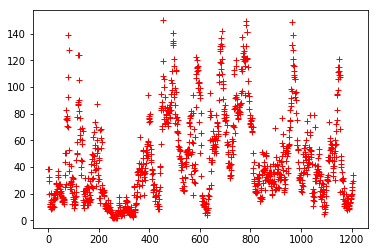

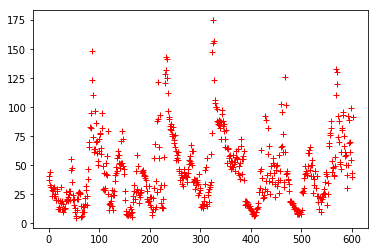

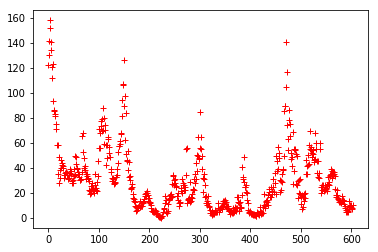

In [6]:
plt.plot(y_train, '+r')
plt.show()
plt.plot(y_valid, '+r')
plt.show()
plt.plot(y_test, '+r')
plt.show()

# Définition des modèles (RNN, LSTM, GRU)

In [7]:
from keras.layers import SimpleRNN, Dense, LSTM, GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def simple_rnn_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(nb_units, input_shape=input_dim, recurrent_dropout=1, activation='relu'))#, recurrent_dropout=1))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def lstm_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(LSTM(nb_units, input_shape=input_dim, activation='relu'))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def gru_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(GRU(nb_units, input_shape=input_dim, activation='relu'))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

Using TensorFlow backend.


## Simple RNN

### Apprentissage

In [8]:
model = simple_rnn_model(32, X_train.shape[1:])
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=10000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1312      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________
Train on 1206 samples, validate on 603 samples
Epoch 1/10000
1206/1206 [==============================] - 0s 160us/step - loss: 3202.1084 - val_loss: 2784.0886
Epoch 2/10000
1206/1206 [==============================] - 0s 44us/step - loss: 3153.4830 - val_loss: 2722.1110
Epoch 3/10000
1206/1206 [==============================] - 0s 44us/step - loss: 3043.8722 - val_loss: 2572.1598
Epoch 4/10000
1206/1

Epoch 68/10000
1206/1206 [==============================] - 0s 43us/step - loss: 107.9280 - val_loss: 128.3551
Epoch 69/10000
1206/1206 [==============================] - 0s 43us/step - loss: 107.5946 - val_loss: 127.5607
Epoch 70/10000
1206/1206 [==============================] - 0s 43us/step - loss: 107.2786 - val_loss: 126.6724
Epoch 71/10000
1206/1206 [==============================] - 0s 43us/step - loss: 107.0003 - val_loss: 125.8969
Epoch 72/10000
1206/1206 [==============================] - 0s 45us/step - loss: 106.7446 - val_loss: 125.1568
Epoch 73/10000
1206/1206 [==============================] - 0s 44us/step - loss: 106.4852 - val_loss: 124.4333
Epoch 74/10000
1206/1206 [==============================] - 0s 43us/step - loss: 106.2538 - val_loss: 123.7067
Epoch 75/10000
1206/1206 [==============================] - 0s 43us/step - loss: 105.9939 - val_loss: 123.0098
Epoch 76/10000
1206/1206 [==============================] - 0s 43us/step - loss: 105.7545 - val_loss: 122.3219
E

Epoch 142/10000
1206/1206 [==============================] - 0s 46us/step - loss: 78.4235 - val_loss: 96.7007
Epoch 143/10000
1206/1206 [==============================] - 0s 52us/step - loss: 77.7932 - val_loss: 96.2672
Epoch 144/10000
1206/1206 [==============================] - 0s 48us/step - loss: 77.0597 - val_loss: 95.8405
Epoch 145/10000
1206/1206 [==============================] - 0s 45us/step - loss: 76.4663 - val_loss: 95.4086
Epoch 146/10000
1206/1206 [==============================] - 0s 45us/step - loss: 75.7527 - val_loss: 95.0029
Epoch 147/10000
1206/1206 [==============================] - 0s 49us/step - loss: 75.1797 - val_loss: 94.5650
Epoch 148/10000
1206/1206 [==============================] - 0s 45us/step - loss: 74.5352 - val_loss: 94.2197
Epoch 149/10000
1206/1206 [==============================] - 0s 44us/step - loss: 73.9929 - val_loss: 93.8556
Epoch 150/10000
1206/1206 [==============================] - 0s 43us/step - loss: 73.3307 - val_loss: 93.4787
Epoch 151/

1206/1206 [==============================] - 0s 45us/step - loss: 54.5388 - val_loss: 81.5308
Epoch 217/10000
1206/1206 [==============================] - 0s 44us/step - loss: 54.4076 - val_loss: 81.4754
Epoch 218/10000
1206/1206 [==============================] - 0s 43us/step - loss: 54.2928 - val_loss: 81.3444
Epoch 219/10000
1206/1206 [==============================] - 0s 43us/step - loss: 54.1205 - val_loss: 81.2102
Epoch 220/10000
1206/1206 [==============================] - 0s 44us/step - loss: 54.0267 - val_loss: 81.1682
Epoch 221/10000
1206/1206 [==============================] - 0s 44us/step - loss: 53.8691 - val_loss: 81.0196
Epoch 222/10000
1206/1206 [==============================] - 0s 44us/step - loss: 53.7561 - val_loss: 80.9243
Epoch 223/10000
1206/1206 [==============================] - 0s 43us/step - loss: 53.6200 - val_loss: 80.7828
Epoch 224/10000
1206/1206 [==============================] - 0s 43us/step - loss: 53.4668 - val_loss: 80.6040
Epoch 225/10000
1206/1206 

1206/1206 [==============================] - 0s 44us/step - loss: 46.6863 - val_loss: 73.4252
Epoch 291/10000
1206/1206 [==============================] - 0s 47us/step - loss: 46.5884 - val_loss: 73.4726
Epoch 292/10000
1206/1206 [==============================] - 0s 43us/step - loss: 46.5078 - val_loss: 73.4241
Epoch 293/10000
1206/1206 [==============================] - 0s 43us/step - loss: 46.4537 - val_loss: 73.4326
Epoch 294/10000
1206/1206 [==============================] - 0s 44us/step - loss: 46.3772 - val_loss: 73.4110
Epoch 295/10000
1206/1206 [==============================] - 0s 47us/step - loss: 46.3483 - val_loss: 73.2761
Epoch 296/10000
1206/1206 [==============================] - 0s 43us/step - loss: 46.2153 - val_loss: 73.3026
Epoch 297/10000
1206/1206 [==============================] - 0s 43us/step - loss: 46.2316 - val_loss: 73.1478
Epoch 298/10000
1206/1206 [==============================] - 0s 43us/step - loss: 46.1286 - val_loss: 73.2000
Epoch 299/10000
1206/1206 

1206/1206 [==============================] - 0s 44us/step - loss: 42.4797 - val_loss: 69.6651
Epoch 365/10000
1206/1206 [==============================] - 0s 45us/step - loss: 42.2291 - val_loss: 69.6957
Epoch 366/10000
1206/1206 [==============================] - 0s 43us/step - loss: 42.1952 - val_loss: 69.4954
Epoch 367/10000
1206/1206 [==============================] - 0s 43us/step - loss: 42.1003 - val_loss: 69.4754
Epoch 368/10000
1206/1206 [==============================] - 0s 45us/step - loss: 42.0619 - val_loss: 69.4539
Epoch 369/10000
1206/1206 [==============================] - 0s 45us/step - loss: 41.9661 - val_loss: 69.5188
Epoch 370/10000
1206/1206 [==============================] - 0s 46us/step - loss: 42.0043 - val_loss: 69.4412
Epoch 371/10000
1206/1206 [==============================] - 0s 45us/step - loss: 41.8552 - val_loss: 69.3514
Epoch 372/10000
1206/1206 [==============================] - 0s 43us/step - loss: 41.8920 - val_loss: 69.3605
Epoch 373/10000
1206/1206 

### Courbes de résultats pour modèle RNN

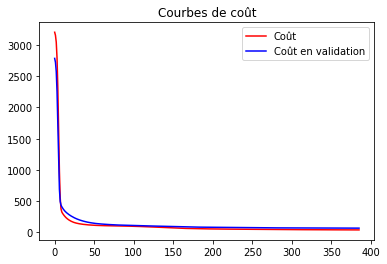

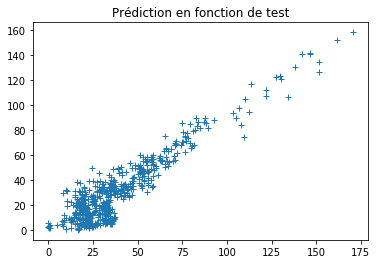

In [9]:
y_pred = model.predict(X_test)
plt.plot(history.history['loss'], 'r-', label="Coût")
plt.plot(history.history['val_loss'], 'b-', label="Coût en validation")
plt.title("Courbes de coût")
plt.legend()
plt.show()

plt.title('y_pred, y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.title("Prédiction en fonction de test")
plt.show()

## LSTM

### Apprentissage

In [10]:
model = lstm_model(32, X_train.shape[1:])
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=10000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________
Train on 1206 samples, validate on 603 samples
Epoch 1/10000
1206/1206 [==============================] - 0s 300us/step - loss: 3214.5500 - val_loss: 2800.0304
Epoch 2/10000
1206/1206 [==============================] - 0s 67us/step - loss: 3191.2104 - val_loss: 2763.3879
Epoch 3/10000
1206/1206 [==============================] - 0s 66us/step - loss: 3121.8289 - val_loss: 2661.8790
Epoch 4/10000
1206/1

Epoch 68/10000
1206/1206 [==============================] - 0s 68us/step - loss: 92.6393 - val_loss: 110.3685
Epoch 69/10000
1206/1206 [==============================] - 0s 66us/step - loss: 91.7358 - val_loss: 109.0383
Epoch 70/10000
1206/1206 [==============================] - 0s 66us/step - loss: 90.8402 - val_loss: 107.7382
Epoch 71/10000
1206/1206 [==============================] - 0s 65us/step - loss: 89.9573 - val_loss: 106.4892
Epoch 72/10000
1206/1206 [==============================] - 0s 63us/step - loss: 89.0904 - val_loss: 105.2955
Epoch 73/10000
1206/1206 [==============================] - 0s 64us/step - loss: 88.2414 - val_loss: 104.1508
Epoch 74/10000
1206/1206 [==============================] - 0s 68us/step - loss: 87.3999 - val_loss: 103.0125
Epoch 75/10000
1206/1206 [==============================] - 0s 72us/step - loss: 86.5774 - val_loss: 101.9098
Epoch 76/10000
1206/1206 [==============================] - 0s 74us/step - loss: 85.7749 - val_loss: 100.8472
Epoch 77/1

1206/1206 [==============================] - 0s 69us/step - loss: 60.0254 - val_loss: 81.2262
Epoch 143/10000
1206/1206 [==============================] - 0s 67us/step - loss: 59.8285 - val_loss: 81.3246
Epoch 00143: early stopping


### Courbes de résultats pour modèle LSTM

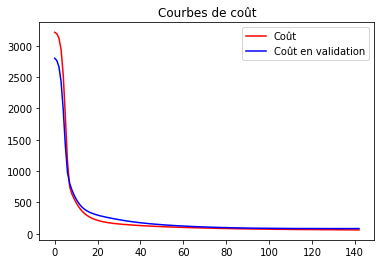

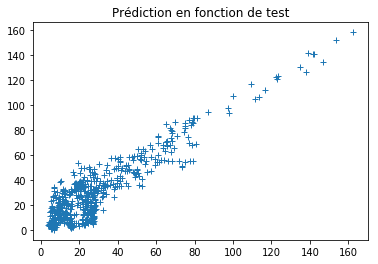

In [11]:
y_pred = model.predict(X_test)
plt.plot(history.history['loss'], 'r-', label="Coût")
plt.plot(history.history['val_loss'], 'b-', label="Coût en validation")
plt.title("Courbes de coût")
plt.legend()
plt.show()

plt.title('y_pred, y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.title("Prédiction en fonction de test")
plt.show()

## GRU

### Apprentissage

In [12]:
model = gru_model(32, X_train.shape[1:])
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=10000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3936      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________
Train on 1206 samples, validate on 603 samples
Epoch 1/10000
1206/1206 [==============================] - 0s 311us/step - loss: 3212.1464 - val_loss: 2797.7950
Epoch 2/10000
1206/1206 [==============================] - 0s 62us/step - loss: 3183.5599 - val_loss: 2756.2778
Epoch 3/10000
1206/1206 [==============================] - 0s 62us/step - loss: 3097.6999 - val_loss: 2638.6341
Epoch 4/10000
1206/1

Epoch 68/10000
1206/1206 [==============================] - 0s 63us/step - loss: 93.2956 - val_loss: 112.7905
Epoch 69/10000
1206/1206 [==============================] - 0s 63us/step - loss: 92.5858 - val_loss: 111.7695
Epoch 70/10000
1206/1206 [==============================] - 0s 60us/step - loss: 91.8934 - val_loss: 110.7649
Epoch 71/10000
1206/1206 [==============================] - 0s 64us/step - loss: 91.2099 - val_loss: 109.8105
Epoch 72/10000
1206/1206 [==============================] - 0s 62us/step - loss: 90.5285 - val_loss: 108.8729
Epoch 73/10000
1206/1206 [==============================] - 0s 61us/step - loss: 89.8588 - val_loss: 107.9618
Epoch 74/10000
1206/1206 [==============================] - 0s 75us/step - loss: 89.1957 - val_loss: 107.0789
Epoch 75/10000
1206/1206 [==============================] - 0s 77us/step - loss: 88.5298 - val_loss: 106.2606
Epoch 76/10000
1206/1206 [==============================] - 0s 66us/step - loss: 87.8868 - val_loss: 105.4956
Epoch 77/1

1206/1206 [==============================] - 0s 67us/step - loss: 62.8486 - val_loss: 80.9163
Epoch 143/10000
1206/1206 [==============================] - 0s 60us/step - loss: 62.6650 - val_loss: 80.8074
Epoch 144/10000
1206/1206 [==============================] - 0s 70us/step - loss: 62.4513 - val_loss: 80.7128
Epoch 145/10000
1206/1206 [==============================] - 0s 62us/step - loss: 62.2035 - val_loss: 80.6137
Epoch 146/10000
1206/1206 [==============================] - 0s 64us/step - loss: 62.0092 - val_loss: 80.5009
Epoch 147/10000
1206/1206 [==============================] - 0s 64us/step - loss: 61.7442 - val_loss: 80.4294
Epoch 148/10000
1206/1206 [==============================] - 0s 63us/step - loss: 61.5659 - val_loss: 80.3127
Epoch 149/10000
1206/1206 [==============================] - 0s 62us/step - loss: 61.3310 - val_loss: 80.2416
Epoch 150/10000
1206/1206 [==============================] - 0s 59us/step - loss: 61.1107 - val_loss: 80.0855
Epoch 151/10000
1206/1206 

1206/1206 [==============================] - 0s 69us/step - loss: 51.0338 - val_loss: 75.4501
Epoch 217/10000
1206/1206 [==============================] - 0s 66us/step - loss: 50.7686 - val_loss: 74.7987
Epoch 218/10000
1206/1206 [==============================] - 0s 66us/step - loss: 50.7462 - val_loss: 75.4630
Epoch 219/10000
1206/1206 [==============================] - 0s 75us/step - loss: 50.5299 - val_loss: 74.3513
Epoch 220/10000
1206/1206 [==============================] - 0s 78us/step - loss: 50.5367 - val_loss: 75.1088
Epoch 221/10000
1206/1206 [==============================] - 0s 81us/step - loss: 50.1420 - val_loss: 74.5129
Epoch 222/10000
1206/1206 [==============================] - 0s 76us/step - loss: 50.3599 - val_loss: 74.8325
Epoch 223/10000
1206/1206 [==============================] - 0s 70us/step - loss: 49.9634 - val_loss: 74.5341
Epoch 224/10000
1206/1206 [==============================] - 0s 71us/step - loss: 49.9087 - val_loss: 74.8138
Epoch 225/10000
1206/1206 

1206/1206 [==============================] - 0s 67us/step - loss: 43.5199 - val_loss: 71.9653
Epoch 291/10000
1206/1206 [==============================] - 0s 62us/step - loss: 43.4303 - val_loss: 71.8175
Epoch 292/10000
1206/1206 [==============================] - 0s 67us/step - loss: 43.2058 - val_loss: 71.4365
Epoch 293/10000
1206/1206 [==============================] - 0s 64us/step - loss: 43.2496 - val_loss: 72.2324
Epoch 294/10000
1206/1206 [==============================] - 0s 61us/step - loss: 43.1235 - val_loss: 71.2786
Epoch 295/10000
1206/1206 [==============================] - 0s 58us/step - loss: 43.1245 - val_loss: 71.9519
Epoch 296/10000
1206/1206 [==============================] - 0s 56us/step - loss: 42.8663 - val_loss: 71.5452
Epoch 297/10000
1206/1206 [==============================] - 0s 57us/step - loss: 43.0734 - val_loss: 71.8327
Epoch 298/10000
1206/1206 [==============================] - 0s 57us/step - loss: 42.6336 - val_loss: 71.3047
Epoch 299/10000
1206/1206 

### Courbes de résultats pour modèle GRU

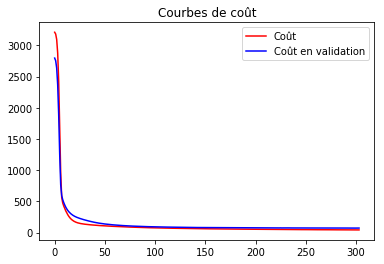

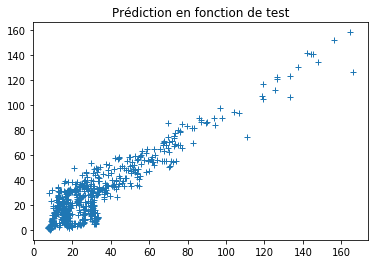

In [13]:
y_pred = model.predict(X_test)
plt.plot(history.history['loss'], 'r-', label="Coût")
plt.plot(history.history['val_loss'], 'b-', label="Coût en validation")
plt.title("Courbes de coût")
plt.legend()
plt.show()

plt.title('y_pred, y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.title("Prédiction en fonction de test")
plt.show()

# Conclusion

Dans ce notebook, nous n'avons pas pu exploité la force des réseaux récurrents qui sont performants sur des données séquentiels, par la prise en compte de séquence unitaire. Dans le notebook suivant, nous essaierons des modèles avec mémoire en prenant en compte de véritables séquences lors de l'apprentissage